In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [2]:
FOURSQUARE_CLIENT_ID = 'C2N4NOCV5L2RPYRIONDBSDKS02BGYYA3RW21WBT4RBAG2Y2M'
FOURSQUARE_CLIENT_SECRET = 'LRYHJRLL5HBIPZBQLZROEIZI1ONXJJX1O1AWRBTTIWNCUZG4'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20190612' # Current date

In [3]:
address = 'Coimbatore'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
CHD_LATITUDE = location.latitude
CHD_LONGITUDE = location.longitude
print(CHD_LATITUDE, CHD_LONGITUDE)

11.0018115 76.9628425


In [4]:
search_query = 'Italian'
radius = 500
offset = 0
total_venues = 0
print(search_query + ' .... OK!')

Italian .... OK!


In [5]:
url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)

In [6]:
url

'https://api.foursquare.com/v2/venues/explore?client_id=C2N4NOCV5L2RPYRIONDBSDKS02BGYYA3RW21WBT4RBAG2Y2M&client_secret=LRYHJRLL5HBIPZBQLZROEIZI1ONXJJX1O1AWRBTTIWNCUZG4&v=20190612&ll=11.0018115,76.9628425&radius=4000&limit=100&offset=0'

In [7]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e402c07d03993001b49214f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Coimbatore',
  'headerFullLocation': 'Coimbatore',
  'headerLocationGranularity': 'city',
  'totalResults': 114,
  'suggestedBounds': {'ne': {'lat': 11.037811536000037,
    'lng': 76.9994480884243},
   'sw': {'lat': 10.965811463999964, 'lng': 76.92623691157569}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ede31ec0aaf49e02e010f39',
       'name': 'The Cinemas',
       'location': {'address': 'Brookefields Plaza, 67-71, Krishnasamy Rd',
        'crossStreet': 'Krishnasamy Road',
        'lat': 11.009058599302957,
        'lng': 76.95939969301797,
        'labeledLatL

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 14 venues fetched within a total radius of 4.0 Km

Total 114 venues fetched


In [10]:
coimbatore_map = folium.Map(location = [11.0018115, 76.9628425], zoom_start = 13)
folium.Marker([11.0018115, 76.9628425]).add_to(coimbatore_map)
coimbatore_map

In [11]:
foursquare_venues

,name,categories,lat,lng
0,The Cinemas,Multiplex,11.009059,76.959400
1,Brookefields Mall,Shopping Mall,11.008875,76.959430
2,"Vivanta by Taj - Surya, Coimbatore",Hotel,11.002026,76.973712
3,Barbeque Nation,BBQ Joint,10.994161,76.963393
4,Delhiwala,Dessert Shop,11.011973,76.962464
5,Junior Kuppana,Indian Restaurant,11.011269,76.965129
6,Barista,Café,11.009090,76.958880
7,Lifestyle,Clothing Store,11.008645,76.959596
8,Sree Annapoorna,Indian Restaurant,11.006873,76.951581
9,Tease,Bar,11.002038,76.973687


In [12]:
headers = {'user-key': '90ee9b252a511d7af77af79055b032d5'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [13]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Arcot Biriyani & Meals Hotel,11.0071017578,76.9578411430,150.0,1.0,3.5,"71, A v.c.v. Layout, Behind Shanmuga Theatre, ..."
1,Cafe Coffee Day,11.0089220000,76.9594670000,650.0,2.0,3.3,"67-71, Inside Brookfields, Brooke Bond Road, R..."
2,Smoke On The Water - Vivanta Coimbatore,11.0020271944,76.9739253446,3000.0,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi..."
3,Barbeque Nation,10.9941971417,76.9633718580,1200.0,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ..."
4,0,0,0,0.0,0.0,0,None
5,Hotel Junior Kuppanna,11.0111619381,76.9650837779,500.0,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ..."
6,0,0,0,0.0,0.0,0,None
7,0,0,0,0.0,0.0,0,None
8,Sree Annapoorna Sweets & Savouries,11.0069500000,76.9516610000,200.0,1.0,0,"75, East Arokiasamy Road, RS Puram, Coimbatore"
9,Tease - Vivanta Coimbatore,11.0020153463,76.9739424437,4000.0,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi..."


In [14]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  


chandigarh_map

In [15]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Arcot Biriyani & Meals Hotel,11.0071017578,76.9578411430,150.0,1.0,3.5,"71, A v.c.v. Layout, Behind Shanmuga Theatre, ..."
1,Cafe Coffee Day,11.0089220000,76.9594670000,650.0,2.0,3.3,"67-71, Inside Brookfields, Brooke Bond Road, R..."
2,Smoke On The Water - Vivanta Coimbatore,11.0020271944,76.9739253446,3000.0,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi..."
3,Barbeque Nation,10.9941971417,76.9633718580,1200.0,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ..."
4,0,0,0,0.0,0.0,0,None
5,Hotel Junior Kuppanna,11.0111619381,76.9650837779,500.0,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ..."
6,0,0,0,0.0,0.0,0,None
7,0,0,0,0.0,0.0,0,None
8,Sree Annapoorna Sweets & Savouries,11.0069500000,76.9516610000,200.0,1.0,0,"75, East Arokiasamy Road, RS Puram, Coimbatore"
9,Tease - Vivanta Coimbatore,11.0020153463,76.9739424437,4000.0,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi..."


In [16]:
foursquare_venues

,name,categories,lat,lng
0,The Cinemas,Multiplex,11.009059,76.959400
1,Brookefields Mall,Shopping Mall,11.008875,76.959430
2,"Vivanta by Taj - Surya, Coimbatore",Hotel,11.002026,76.973712
3,Barbeque Nation,BBQ Joint,10.994161,76.963393
4,Delhiwala,Dessert Shop,11.011973,76.962464
5,Junior Kuppana,Indian Restaurant,11.011269,76.965129
6,Barista,Café,11.009090,76.958880
7,Lifestyle,Clothing Store,11.008645,76.959596
8,Sree Annapoorna,Indian Restaurant,11.006873,76.951581
9,Tease,Bar,11.002038,76.973687


In [17]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [18]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [19]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Brookefields Mall,Shopping Mall,11.0089,76.9594,Cafe Coffee Day,11.0089,76.9595,650.0,2.0,3.3,"67-71, Inside Brookfields, Brooke Bond Road, R...",0.0000,0.0001
1,"Vivanta by Taj - Surya, Coimbatore",Hotel,11.0020,76.9737,Smoke On The Water - Vivanta Coimbatore,11.0020,76.9739,3000.0,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi...",0.0000,0.0002
2,Barbeque Nation,BBQ Joint,10.9942,76.9634,Barbeque Nation,10.9942,76.9634,1200.0,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ...",0.0000,0.0000
3,Junior Kuppana,Indian Restaurant,11.0113,76.9651,Hotel Junior Kuppanna,11.0112,76.9651,500.0,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ...",-0.0001,0.0000
4,Sree Annapoorna,Indian Restaurant,11.0069,76.9516,Sree Annapoorna Sweets & Savouries,11.0069,76.9517,200.0,1.0,0,"75, East Arokiasamy Road, RS Puram, Coimbatore",0.0000,0.0001
5,Tease,Bar,11.0020,76.9737,Tease - Vivanta Coimbatore,11.0020,76.9739,4000.0,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi...",0.0000,0.0002
6,Hotel Hari Bhavan,Indian Restaurant,11.0084,76.9750,Hari Bhavanam,11.0086,76.9751,600.0,2.0,3.7,"Shop 64, Balasundaram Road, RTO Office Road, H...",0.0002,0.0001
7,The Village,Asian Restaurant,11.0085,76.9570,The Village,11.0085,76.9567,300.0,1.0,4.1,"61, RR Layout, Near Shanmuga Theatre, RS Puram...",0.0000,-0.0003
8,Cream Centre,Vegetarian / Vegan Restaurant,11.0035,76.9759,Cream Centre,11.0035,76.9759,1000.0,3.0,4.4,"128/180, Orbit Avenue, Thirugnanasambandam Roa...",0.0000,0.0000
9,Sree Annapoorna Gowrishankar,Indian Restaurant,11.0000,76.9711,Sree Annapoorna Sree Gowrishankar,11.0000,76.9712,250.0,1.0,4.5,"2, Peoples Park, Arts College Road, Opposite C...",0.0000,0.0001


In [20]:
selected_venues = selected_venues.drop([0, 20, 25, 29, 32, 34, 47, 49, 56, 57, 58, 59, 60]).reset_index(drop = True)

In [21]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [22]:
selected_venues

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Smoke On The Water - Vivanta Coimbatore,11.0020,76.9739,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi...",1500.0
1,BBQ Joint,Barbeque Nation,10.9942,76.9634,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ...",600.0
2,Indian Restaurant,Hotel Junior Kuppanna,11.0112,76.9651,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ...",250.0
3,Indian Restaurant,Sree Annapoorna Sweets & Savouries,11.0069,76.9517,1.0,0,"75, East Arokiasamy Road, RS Puram, Coimbatore",100.0
4,Bar,Tease - Vivanta Coimbatore,11.0020,76.9739,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi...",2000.0
5,Indian Restaurant,Hari Bhavanam,11.0086,76.9751,2.0,3.7,"Shop 64, Balasundaram Road, RTO Office Road, H...",300.0
6,Asian Restaurant,The Village,11.0085,76.9567,1.0,4.1,"61, RR Layout, Near Shanmuga Theatre, RS Puram...",150.0
7,Vegetarian / Vegan Restaurant,Cream Centre,11.0035,76.9759,3.0,4.4,"128/180, Orbit Avenue, Thirugnanasambandam Roa...",500.0
8,Indian Restaurant,Sree Annapoorna Sree Gowrishankar,11.0000,76.9712,1.0,4.5,"2, Peoples Park, Arts College Road, Opposite C...",125.0
9,Hotel,The Afghan Grill - The Residency Hotel,11.0103,76.9806,4.0,4.1,"The Residency Hotel, 1075/1076, Avinashi Road,...",1000.0


In [23]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 42


In [24]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

<BarContainer object of 22 artists>

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Count of venues with given rating')

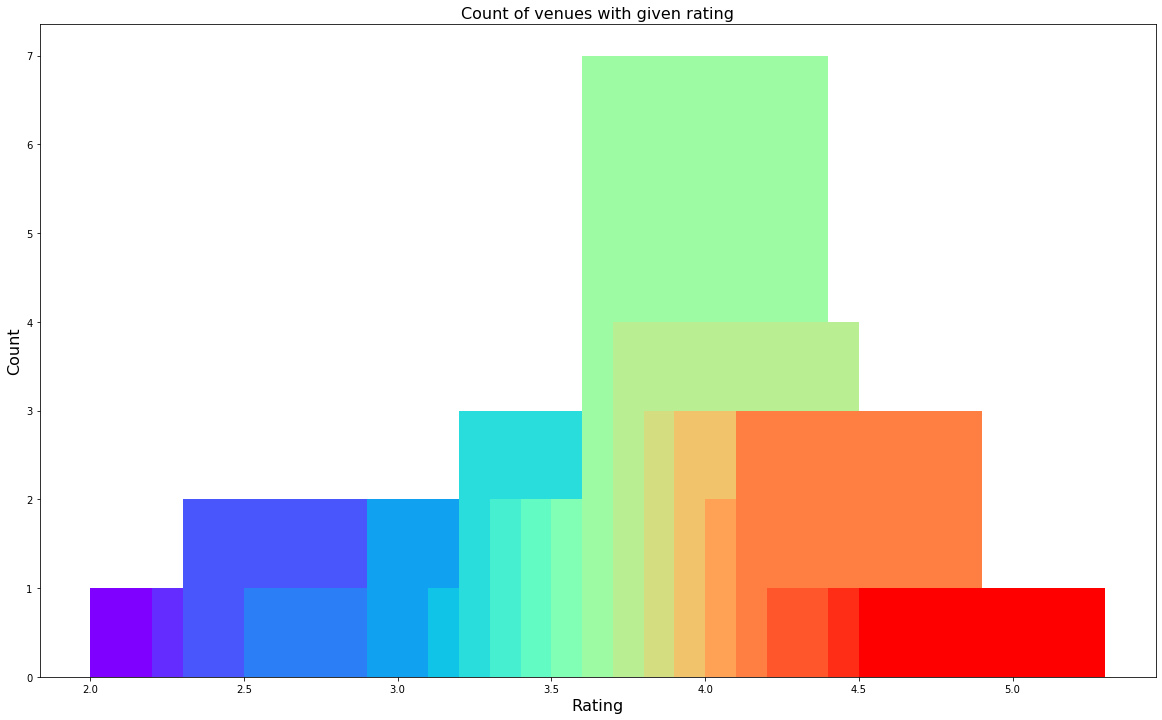

In [25]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [26]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
color_map = {'Low': 'red', 'Okay': 'red', 'Good': 'red', 'Very good': 'red'}

chandigarh2_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chandigarh2_map)  

chandigarh2_map

In [28]:
selected_venues.shape

(42, 9)

Text(0.5, 1.0, 'Count of venues with given average price')

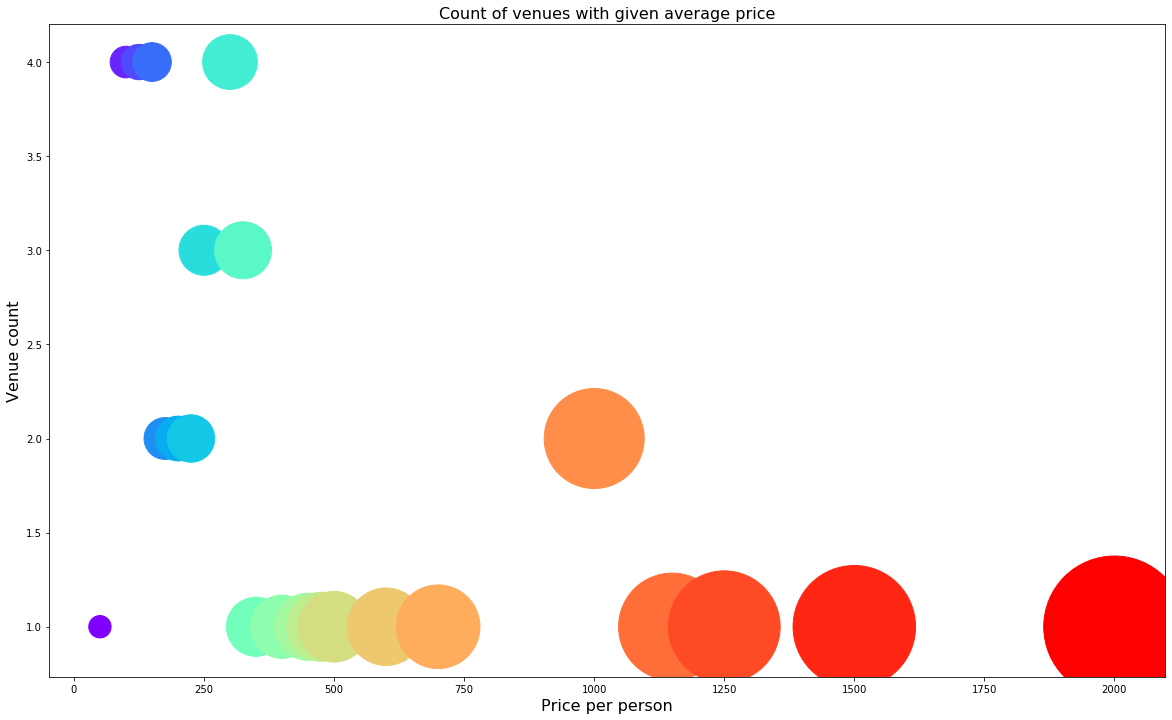

In [29]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [30]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh3_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh3_map)  

chandigarh3_map

In [31]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head()

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hotel,Smoke On The Water - Vivanta Coimbatore,11.0020,76.9739,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi...",1500.0,Good
1,1,BBQ Joint,Barbeque Nation,10.9942,76.9634,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ...",600.0,Very good
2,1,Indian Restaurant,Hotel Junior Kuppanna,11.0112,76.9651,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ...",250.0,Very good
4,0,Bar,Tease - Vivanta Coimbatore,11.0020,76.9739,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi...",2000.0,Good
5,1,Indian Restaurant,Hari Bhavanam,11.0086,76.9751,2.0,3.7,"Shop 64, Balasundaram Road, RTO Office Road, H...",300.0,Good


In [32]:
chandigarh4_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chandigarh_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chandigarh4_map)

chandigarh4_map

In [33]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hotel,Smoke On The Water - Vivanta Coimbatore,11.0020,76.9739,4.0,3.6,"Vivanta Coimbatore, 105, Race Course Road, Coi...",1500.0,Good
1,0,Bar,Tease - Vivanta Coimbatore,11.0020,76.9739,4.0,3.8,"Vivanta Coimbatore, 105, Race Course Road, Coi...",2000.0,Good
2,0,Hotel,The Afghan Grill - The Residency Hotel,11.0103,76.9806,4.0,4.1,"The Residency Hotel, 1075/1076, Avinashi Road,...",1000.0,Very good
3,0,Restaurant,Latitude - Vivanta Coimbatore,11.0020,76.9740,4.0,4.0,"Vivanta Coimbatore, 105, Race Course Road, Coi...",1150.0,Good
4,0,Chinese Restaurant,Chin Chin - The Residency Hotel,11.0102,76.9806,4.0,4.2,"The Residency Hotel, 1075/1076, Avinashi Road,...",1250.0,Very good
5,0,Nightclub,Bikes & Barrels - The Residency Hotel,11.0102,76.9806,4.0,4.0,"The Residency Hotel, 1075/1076, Avinashi Road,...",1000.0,Good


In [34]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 4.00 and rating spread around 3.95


In [35]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,BBQ Joint,Barbeque Nation,10.9942,76.9634,3.0,4.8,"6th Floor, Metro Park Inn, 1000, Raja Street, ...",600.0,Very good
1,1,Indian Restaurant,Hotel Junior Kuppanna,11.0112,76.9651,2.0,4.3,"177, Sarojini Street, Ram Nagar, Gandhipuram, ...",250.0,Very good
2,1,Indian Restaurant,Hari Bhavanam,11.0086,76.9751,2.0,3.7,"Shop 64, Balasundaram Road, RTO Office Road, H...",300.0,Good
3,1,Asian Restaurant,The Village,11.0085,76.9567,1.0,4.1,"61, RR Layout, Near Shanmuga Theatre, RS Puram...",150.0,Very good
4,1,Vegetarian / Vegan Restaurant,Cream Centre,11.0035,76.9759,3.0,4.4,"128/180, Orbit Avenue, Thirugnanasambandam Roa...",500.0,Very good
5,1,Indian Restaurant,Sree Annapoorna Sree Gowrishankar,11.0000,76.9712,1.0,4.5,"2, Peoples Park, Arts College Road, Opposite C...",125.0,Very good
6,1,Indian Restaurant,Valarmathi Kongunaatu Samayal,11.0018,76.9760,2.0,4.9,"207/A, CSI Compound, Opposite Photo Centre, Ra...",225.0,Very good
7,1,Ice Cream Shop,Richy Rich,10.9984,76.9765,1.0,4.0,"51, Near Jayams Hall, Race Course, Coimbatore",125.0,Good
8,1,Indian Restaurant,Burma Bhai Hotel,11.0056,76.9691,2.0,3.9,"64, Near VOC Park, Nehru Stadium, Coimbatore",175.0,Good
9,1,Bakery,Chocko Choza,11.0132,76.9519,2.0,4.0,"18 A, Periyaswamy Road East, RS Puram, Coimbatore",300.0,Good


In [36]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.81 and rating spread around 3.88
